In [1]:
%pylab inline
#import matplotlib as mpl
#mpl.rcParams['mathtext.default'] = 'rm'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import emcee

In [ ]:
#Open questions:
#1) what is the purpose of the covariance matrix? How do I translate this to the equations
#   from the paper?
#
#2) What are walkers and how do they work?
#
#3) I generally understand the Gaussian they construct in the model fit, but I don't know
#   where the factor of f^2*(mx+b) comes from

In [4]:
#I'm just going to reproduce the tutorial for emcee

#First define the log of the probability which for the example is a guassian and we also
#need the log of the probability which emcee uses

def log_prob(x,mu,cov):
    diff = x - mu
    return - 0.5*np.dot(diff, np.linalg.solve(cov,diff))

#note that the first argument must be the position of a single walker (an N dimensional
#numpy array)

In [5]:
#now we need to set up hyperparameters in a 5-d space
ndim = 5
np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim,ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

In [6]:
#now we need to choose the number of walkers?
#
#They admit its bad but they choose 32 walkers and set their values to a random number between
# 1 and 0. It's a 5d space so a 32X5 array

nwalkers = 32
p0 = np.random.rand(nwalkers,ndim)

In [7]:
#initalize the sampler

sampler = emcee.EnsembleSampler(nwalkers,ndim,log_prob,args=[means,cov])

In [8]:
#Now we need burn in steps to get the mcmc to understand the parameter space

state = sampler.run_mcmc(p0,100)
sampler.reset()

#reseting removes everything, but state saves the state of the MCMC at that point

In [9]:
#Now it's time for the production run

sampler.run_mcmc(state,1000)

State([[-0.22358482  3.30753728  1.18977171  0.37369529  0.5273909 ]
 [-0.10895051  0.37963262  0.29707029  0.6059237   0.43082865]
 [ 0.34183292  1.92204923  1.44698866 -0.09870001 -1.11071458]
 [ 0.54906931  1.57899062  0.86971145  0.22708435 -0.3748355 ]
 [ 0.80626101  0.96857325  0.39211464  0.58267362 -0.51860448]
 [ 1.37028539  0.17442897  0.05501326  0.5924762   0.69684309]
 [ 0.07145135  2.13114978  1.31209222  0.29446866 -0.29440913]
 [ 1.1676342   1.60935236  0.14573636  0.4627059  -0.0850834 ]
 [ 0.14464806  0.69575773  0.59634451  0.90134919  0.43307016]
 [-0.52756953 -0.07450786  1.39870812  1.04151123  1.37548524]
 [ 0.83522458  0.14718589  0.80264381  0.95614925  1.04559891]
 [ 1.52426991  1.22630576 -0.1678546   0.39764414 -0.60732191]
 [-0.23132752  1.79874578  1.0968126  -0.35496595 -0.92668353]
 [-0.07570597  2.22993576  0.89560201  0.06545996 -0.56129849]
 [ 0.61468064  1.20248086  0.77904714  0.63455904 -0.26140185]
 [-0.47480551  0.48180755  0.99819187  0.67263228

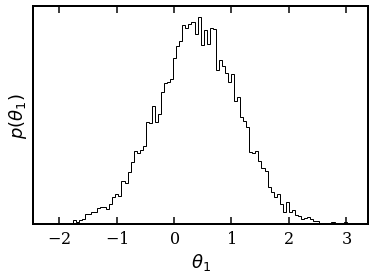

In [10]:
samples = sampler.get_chain(flat=True)

#Get chain gives you the state of the values of the matrix at all of the 1000 
#steps that I ran the MCMC

plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

(1000, 32, 5)


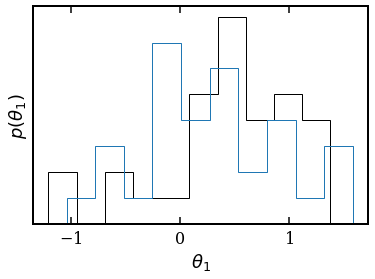

In [17]:
samples = sampler.get_chain()

print(samples.shape)

first_sample = samples[0,:,0]
last_sample = samples[999,:,0]

plt.hist(first_sample, 10, color="k", histtype="step")
plt.hist(last_sample, 10, color="C0", histtype="step")

plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [18]:
#I think this is just a fancy way to sample a gaussian. 
#Is this delibrate? they don't really say

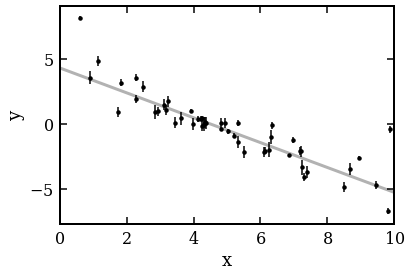

In [20]:
#Fitting a model to data

#we're going to first do a simple linear model by generating data with errors:


np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


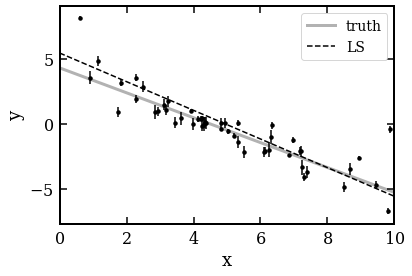

In [22]:
#They deliberately underestimated the error bars for a simple reason. If you try to do just
#a simple inear least squares fit:

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

You get something off with small error bars
the least squares solution would be the maximum likelihood result if the errorbars were
correct, Gaussian and independant, but they aren't so it is not.

We know of no algorithm to do this when the error are wrong, so what we need to do is write
down the likelihood and numerically optimize it

The correct likelihood is:

$$ \Large ln  p(y|x,\sigma,m,b,f) = - \frac{1}{2} \sum_{n} \Big[ \frac{(y_n - m x_n - b)^2}{s^2_n} \Big] $$

where;

$$ \Large s^2_n = \sigma^2_n + f^2 (m x_n +b )^2 $$

So I think what they're saying here is that we have a Gaussian where the variance $s_n^2$ is the true variance $\sigma^2_n$ minus some fraction f. 

*I'm not sure why the f is multiplied by the linear equation though*

In [23]:
#Now we code up this Gaussian

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


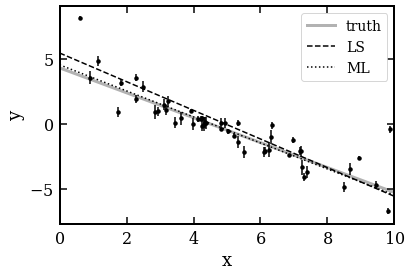

In [24]:
#We can now simply optimize this function

from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [25]:
#and hey! that's pretty good
#This is simply using the maximum likelihood method

In [26]:
#Now we want to actually do this using an MCMC
#
#for this we need priors on our parameters, which for a linear equation are m, b and the log of f
#
#They're going to use an "uninformative" prior 
#
# for m this will be a piecewise function that is 1/(5.5) if -5 < m < 1/2, else 0
# (I think this is just normalized to 1)

In [28]:
def log_prior(theta):
    m,b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return np.inf

#The full log probability function is the prior times the likelihood (or added to in the 
#case of log probability)

def log_probability(theta,x,y,yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [29]:
#Now we can initialize the MCMC they're going to start around the maximum likelihood
#parameters

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 590.77it/s]


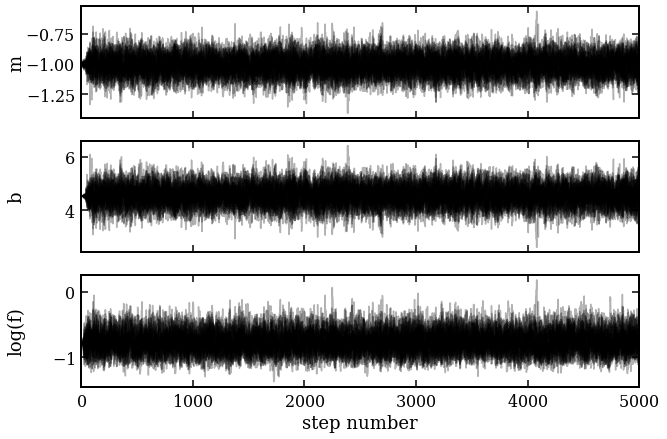

In [30]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [31]:
tau = sampler.get_autocorr_time()
print(tau)

[39.16329084 39.96660169 35.8864348 ]


In [32]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


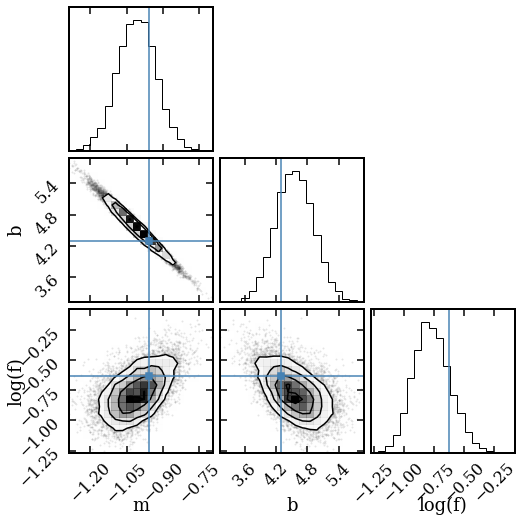

In [33]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

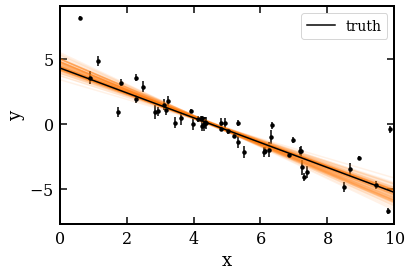

In [34]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
#So to distill what I think is going on here. It seems like the maximum likelihood method
#just gives the best fit of the parameters whereas a full MCMC gives a probability distribution

